# Import block

In [158]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from catboost import CatBoostRegressor

import holidays
import datetime
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Function block

In [424]:
def create_features_from_date(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Using date and time creating new features
    '''
    df['date'] = pd.to_datetime(df.index.date)
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    
    return df


def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Creating 3 lags
    '''
    df['lag1'] = df['PJME_MW'].shift(31440)
    df['lag2'] = df['PJME_MW'].shift(45440)
    df['lag3'] = df['PJME_MW'].shift(60440)
    return df


def plot_feature_importance(importance, names, model_type):
    '''
    Plot most important features of models
    '''
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data = {"feature_names": feature_names, "feature_imporance": feature_importance}
    feat = pd.DataFrame(data)[:20]
    feat.sort_values(by=["feature_imporance"], ascending=False, inplace=True)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feat["feature_imporance"], y=feat["feature_names"])
    plt.title(model_type + " feature imporance")
    plt.xlabel("feature imporance")
    plt.ylabel("feature names")
    
    
def plot_original_and_predicted(df, original_label, predicted_label):
    fig, ax = plt.subplots(figsize=(15, 5))
    fig = df[original_label].plot(lw=1, ax=ax, legend=original_label)
    fig = df[predicted_label].plot(lw=1, ax=ax, legend=predicted_label)
    ax.axvline('01-01-2015', ls='--', color='black', lw=2)
    plt.show()
    
    
def print_metrics(df: pd.DataFrame, df_pred: pd.DataFrame):
    '''
    Printing metrics (MSE, RMSE, MAE, MAPE)
    skleast import needed:
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    '''
    mse = mean_squared_error(df, df_pred)
    print(f'MSE is: {mse}')
    print(f'RMSE is: {np.sqrt(mse)}')
    print(f'MAE is: {mean_absolute_error(df, df_pred)}')
    print(f'MAPE is: {mean_absolute_percentage_error(df, df_pred)}')
    

def add_is_calendar(df: pd.DataFrame) -> pd.DataFrame:
    cal = calendar()
    holidays = cal.holidays(start=pjme.index.min(), end=pjme.index.max(), return_name=True)
    holidays = pd.DataFrame(data=holidays, columns=['holiday'])
    df['date'] = pd.to_datetime(df.index.date)
    df['is_holiday'] = df.join(holidays, on='date')['holiday'].notna().astype(int)
    df.drop('date', axis=1, inplace=True)
    return df

# Loading Data

In [388]:
pjme = pd.read_csv('data\\part_3\\PJME_hourly.csv', index_col=[0], parse_dates=[0])

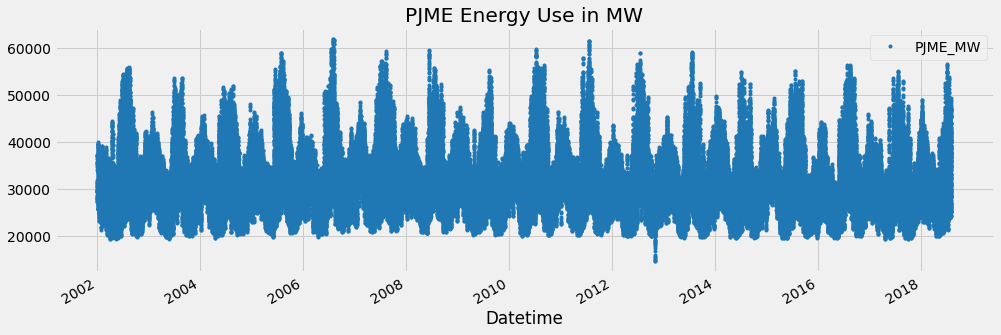

In [8]:
pjme.plot(
    style='.',
    figsize=(15, 5),
    color=color_pal[0],
    title='PJME Energy Use in MW'
)
plt.show()

In [60]:
pjme.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


# Задание 1. Правильно разбейте данные по train и test

In [389]:
train = pjme.query("Datetime < '01-01-2015'").copy()
test = pjme.query("Datetime >= '01-01-2015'").copy()

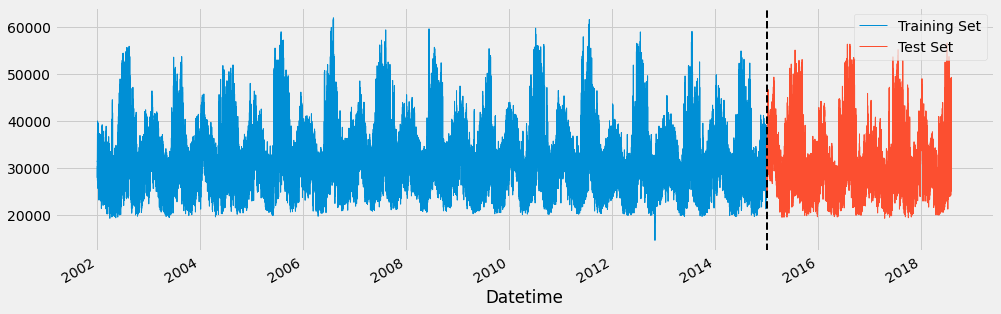

In [390]:
fig, ax = plt.subplots(figsize=(15, 5))
train.rename(columns={'PJME_MW': 'Training Set'}).plot(lw=1, ax=ax)
test.rename(columns={'PJME_MW': 'Test Set'}).plot(lw=1, ax=ax)
ax.legend=(['Train', 'Test'])
ax.axvline('01-01-2015', ls='--', color='black', lw=2)
plt.show()

# Задание 2. Создание временных принзаков по datetime

In [391]:
train = create_features_from_date(train)
test = create_features_from_date(test)
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 
            'dayofyear', 'dayofmonth', 'weekofyear']
target = 'PJME_MW'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# Задание 3.1 XGBoost Model

## Инициализация модели XGBoost

In [392]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)

## Обучение модели XGBoost

In [394]:
xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Важность признаков XGBoost

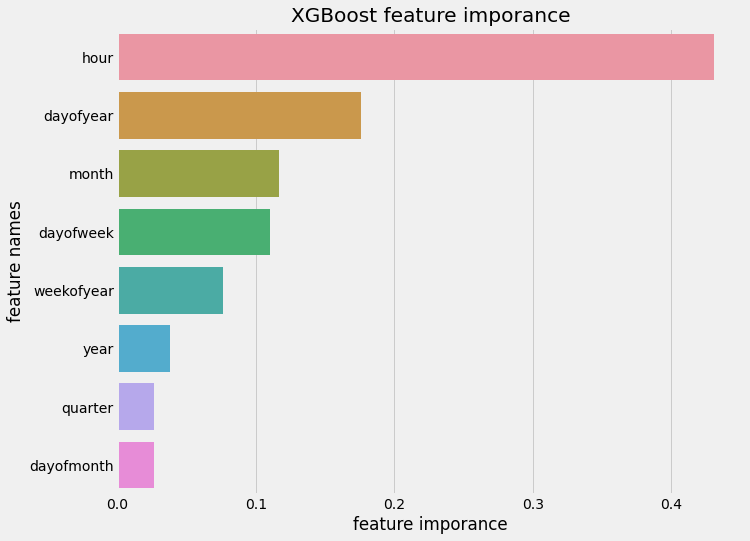

In [395]:
plot_feature_importance(xgb_model.feature_importances_, xgb_model.feature_names_in_, 'XGBoost')

## Прогноз модели XGBoost

In [396]:
test['MW_Prediction'] = xgb_model.predict(X_test)
pjme = pd.concat([test, train], sort=False)

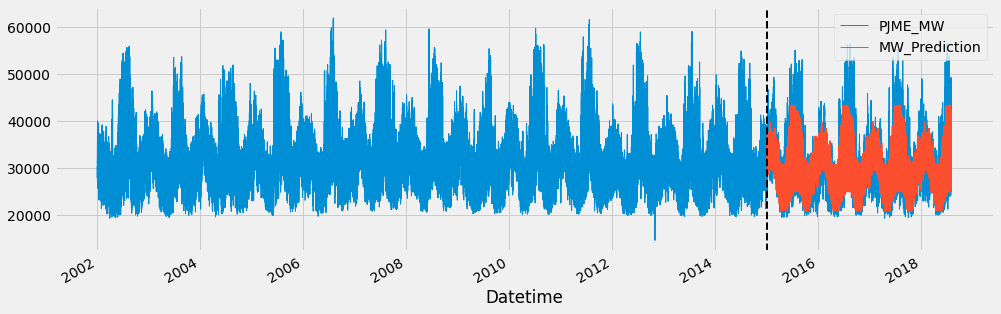

In [398]:
plot_original_and_predicted(pjme, 'PJME_MW', 'MW_Prediction')

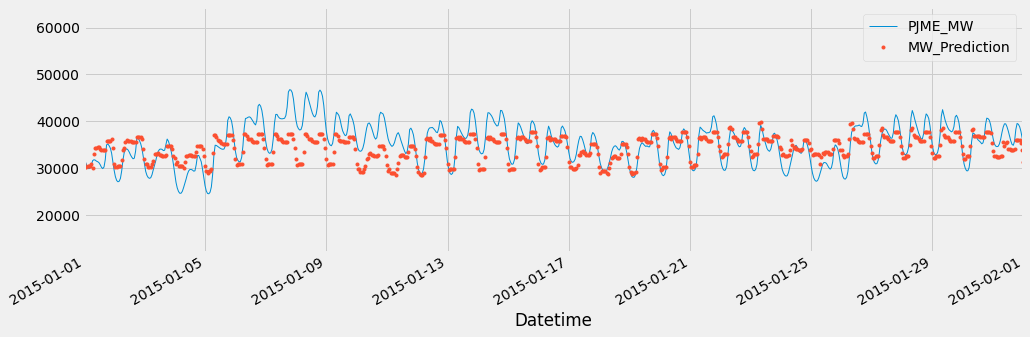

In [273]:
fig, ax = plt.subplots(figsize=(15, 5))
fig = pjme['PJME_MW'].plot(lw=1, ax=ax, legend='PJME_MW')
fig = pjme['MW_Prediction'].plot(lw=1, ax=ax, legend='MW_Prediction', style='.')
ax.legend=(['Original', 'Predicted'])
ax.axvline('01-01-2015', ls='--', color='black', lw=2)
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
plt.show()

# Задание 3.2 CATBoost Model

## Инициализация модели CATBoost

In [399]:
catb_model = CatBoostRegressor(n_estimators=1000)

## Обучение модели CATBoost

In [400]:
catb_model.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               early_stopping_rounds=50,
               verbose=False)

## Важность признаков CATBoost

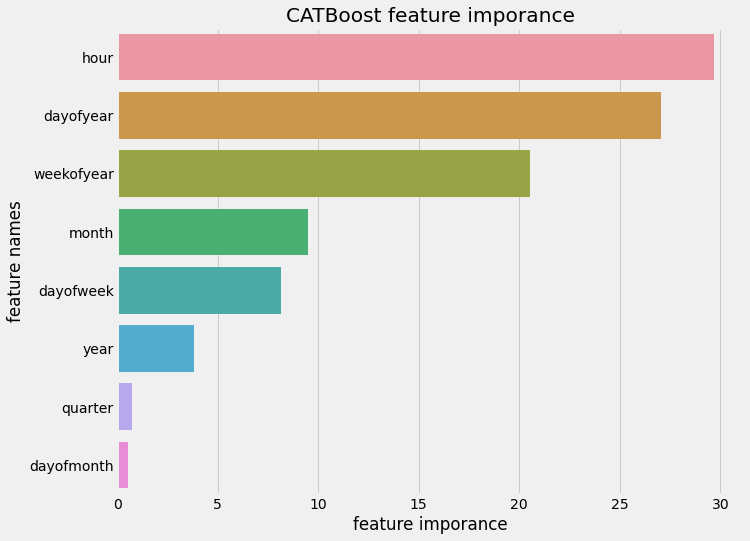

In [278]:
plot_feature_importance(catb_model.feature_importances_, catb_model.feature_names_, 'CATBoost')

## Прогноз модели CATBoost

In [401]:
test['MW_Prediction_CatBoost'] = catb_model.predict(X_test)
pjme = pd.concat([test, train], sort=False)

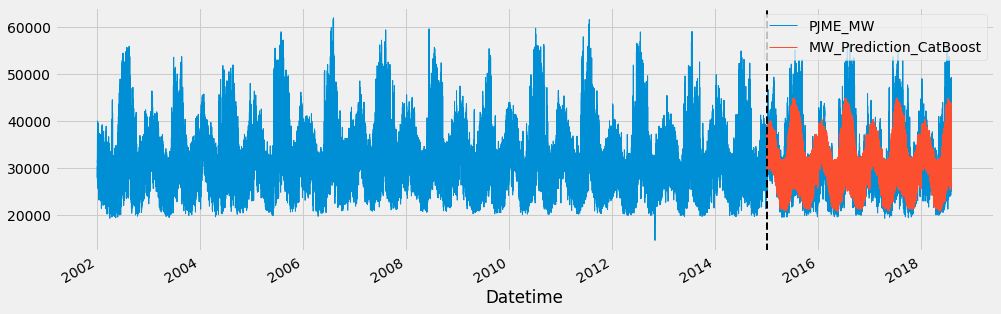

In [402]:
plot_original_and_predicted(pjme, 'PJME_MW', 'MW_Prediction_CatBoost')

# Задание 7. Оцените метрики MAE, MAPE, MSE по результатам двух моделей. Сравните, сделайте выводы.

In [403]:
print('Metrics for XGBoost model')
print_metrics(y_test, test['MW_Prediction'])

Metrics for XGBoost model
MSE is: 13972594.561315235
RMSE is: 3737.9933870079594
MAE is: 2758.3374049528866
MAPE is: 0.08514829643514457


In [404]:
print('Metrics for CATBoost model')
print_metrics(y_test, test['MW_Prediction_CatBoost'])

Metrics for CATBoost model
MSE is: 13832357.136873398
RMSE is: 3719.187698526843
MAE is: 2848.902905684462
MAPE is: 0.08955850665060232


# Задание 8. Добавить данные о праздничных днях.

In [405]:
train = add_is_calendar(train)
test = add_is_calendar(test)

In [406]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 
            'dayofyear', 'dayofmonth', 'weekofyear', 'is_holiday']
target = 'PJME_MW'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# Задание 9. Обучение моделей. Фиксация метрик.

## Модель XGBoost с данными о праздниках.

In [407]:
xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [408]:
test['MW_Prediction_WHolidays'] = xgb_model.predict(X_test)
pjme = pd.concat([test, train], sort=False)

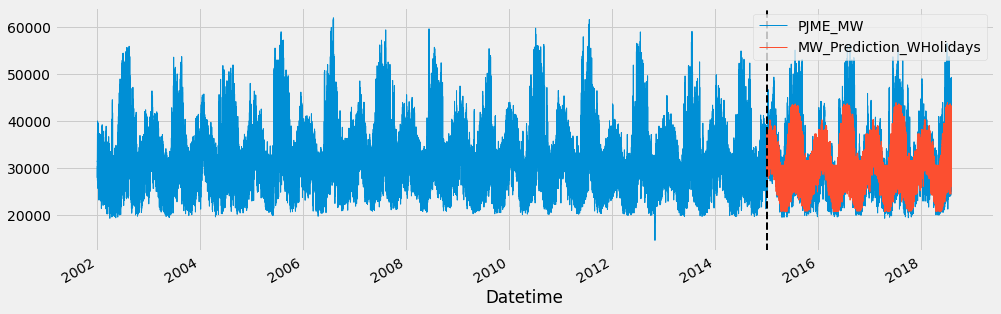

In [412]:
plot_original_and_predicted(pjme, 'PJME_MW', 'MW_Prediction_WHolidays')

## Модель CATBoost с данными о праздниках.

In [409]:
catb_model.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               early_stopping_rounds=50,
               verbose=False)

In [410]:
test['MW_Prediction_CatBoost_WHolidays'] = catb_model.predict(X_test)
pjme = pd.concat([test, train], sort=False)

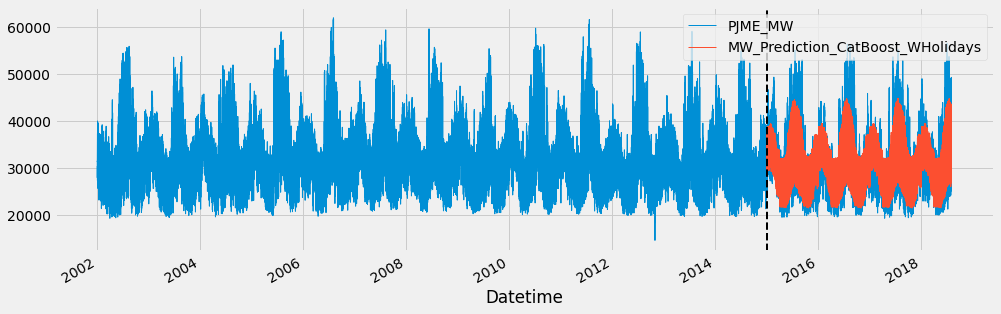

In [413]:
plot_original_and_predicted(pjme, 'PJME_MW', 'MW_Prediction_CatBoost_WHolidays')

## Метрики XGBoost с данными о праздниках.

In [311]:
print('Metrics for XGBoost model with holidays')
print_metrics(y_test, test['MW_Prediction_WHolidays'])

Metrics for XGBoost model with holidays
MSE is: 13877012.925788622
RMSE is: 3725.186294105118
MAE is: 2766.260418840947
MAPE is: 0.08542339901155512


## Метрики CATBoost с данными о праздниках.

In [312]:
print('Metrics for CATBoost model with holidays')
print_metrics(y_test, test['MW_Prediction_CatBoost_WHolidays'])

Metrics for CATBoost model with holidays
MSE is: 13483589.314149601
RMSE is: 3672.0007236041774
MAE is: 2858.3143409632053
MAPE is: 0.09034401413164568


# Задание 10. Добавим лаги.

In [414]:
# reread dataset
pjme = pd.read_csv('data\\part_3\\PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [415]:
pjme = create_features_from_date(pjme)
pjme = add_lags(pjme)
pjme = add_is_calendar(pjme)

In [416]:
train = pjme.query("Datetime < '01-01-2015'").copy()
test = pjme.query("Datetime >= '01-01-2015'").copy()

In [417]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 
            'dayofyear', 'dayofmonth', 'weekofyear', 'is_holiday', 'lag1', 'lag2', 'lag3']
target = 'PJME_MW'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [378]:
pjme

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,is_holiday
Datetime,,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,NaN,NaN,NaN,0
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,NaN,NaN,NaN,0
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,NaN,NaN,NaN,0
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,NaN,NaN,NaN,0
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,36447.0,34228.0,23087.0,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,36193.0,35416.0,24105.0,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,35601.0,36303.0,25306.0,1


# Задание 11. Пересчитайте модели. Выводы.

## Модель XGBoost

In [418]:
xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [419]:
test['MW_Prediction_WHolidays_and_lags'] = xgb_model.predict(X_test)
pjme = pd.concat([test, train], sort=False)

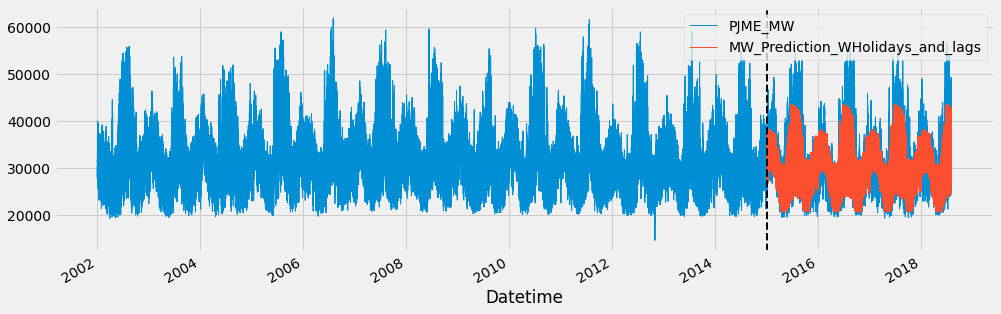

In [420]:
plot_original_and_predicted(pjme, 'PJME_MW', 'MW_Prediction_WHolidays_and_lags')

## Модель CATBoost

In [421]:
catb_model.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               early_stopping_rounds=50,
               verbose=False)

In [422]:
test['MW_Prediction_CatBoost_WHolidays_and_lags'] = catb_model.predict(X_test)
pjme = pd.concat([test, train], sort=False)

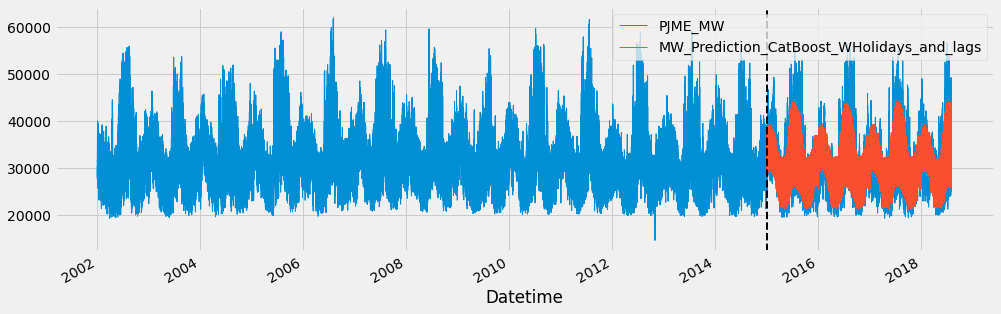

In [423]:
plot_original_and_predicted(pjme, 'PJME_MW', 'MW_Prediction_CatBoost_WHolidays_and_lags')

## Метрики XGBoost

In [356]:
print('Metrics for XGBoost model with holidays and lags')
print_metrics(y_test, test['MW_Prediction_WHolidays_and_lags'])

Metrics for XGBoost model with holidays and lags
MSE is: 14171083.73498324
RMSE is: 3764.4499910323207
MAE is: 2787.5291056004494
MAPE is: 0.08590818364953115


## Метрики CATBoost

In [357]:
print('Metrics for CATBoost model with holidays')
print_metrics(y_test, test['MW_Prediction_CatBoost_WHolidays_and_lags'])

Metrics for CATBoost model with holidays
MSE is: 13750668.211089665
RMSE is: 3708.1893440181375
MAE is: 2890.1914878135076
MAPE is: 0.09127029331045945


## Выводы

Итак, я построил модели XGBoost и CATBoost на таймсерии. Модели "из коробки" дают не плохой результат. Следуют за сезонностью. Пиковые значения не отрабатываются.  
При добавлении информации о праздниках ошибка несколько уменьшилась. Добавление лагов немного испортило картину.  
Для улучшения модели в дальнейшем нужно посмотреть выбросы. Как минимум убрать аномалию вниз в конце 2012 года. Также можно наложить историю погоды и т.д. 
Ну, и конечно, подобрать гиперпараметры для моделей.